## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from numba import jit

In [2]:
# Set the seed
seed = 42
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In [3]:
if torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print ("MPS device not found.")

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128
#train_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor(),
#                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

#test_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                    transforms.ToTensor(),
#                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.Resize((size, size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Resize([256, 256]),
    #torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Resize((size, size)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

batch_size = 2
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
# DATA_MEANS = (trainset.data / 255.0).mean(axis=(0,1,2))
# DATA_STD = (testset.data / 255.0).std(axis=(0,1,2))
# print("Data mean", DATA_MEANS)
# print("Data std", DATA_STD)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


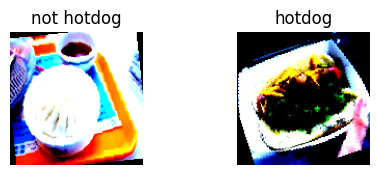

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(batch_size):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn=nn.ReLU, c_out=-1, channel_change=False, strides=1):
        '''
        Args:
            c_in: number of input features
            act_fn: activation function
            c_out: number of output features
        '''
        super().__init__()

        self.act_fn = act_fn()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            self.act_fn,
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )
        
        if channel_change:
            self.conv3 = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

    def forward(self, x):
        z = self.net(x)
        if self.conv3:
            x = self.conv3(x)
        out = x + z
        out = self.act_fn(out)
        return out

In [8]:
block = ResNetBlock(c_in=64, c_out=64)
x = torch.randn(1, 64, 32, 32 )
x = x.to(device)  # Batch size 1, 64 channels, 32x32 image
block = block.to(device)
out = block(x)
print(out.shape) # Should output (1, 64, 32, 32)

torch.Size([1, 64, 32, 32])


In [9]:
class Network(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[2,2,2,2], c_hidden=[16,32,32,32], act_fn_name="relu",):
        super(Network, self).__init__()

        self.act_fn_name = act_fn_name

        if act_fn_name == "relu":
            act_fn = nn.ReLU
        elif act_fn_name == "leaky_relu":
            act_fn = nn.LeakyReLU
        else:
            raise ValueError("Unknown activation function")
        
        self.input_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            act_fn()
        )


        resnet_blocks = []
        channel_change = False
        for idx, block_size in enumerate(num_blocks):
            c_in = c_hidden[idx]
            c_out = c_hidden[idx]
            for j in range(block_size):
                if j == 0 and idx > 0:
                    c_in = c_hidden[idx-1]
                    channel_change = True
                resnet_blocks.append(ResNetBlock(c_in=c_in, act_fn=act_fn, c_out=c_out, channel_change=channel_change))
                c_in = c_out
                channel_change = False
        self.resnet_blocks = nn.Sequential(*resnet_blocks)

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(c_out, num_classes)
        )
    
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.resnet_blocks(x)
        x = self.output_net(x)
        return x        

In [70]:
class SimpleNetwork(nn.Module):
    def __init__(self, num_classes=2, c_hidden=[16,32,32,32], act_fn_name="relu",):
        super(SimpleNetwork, self).__init__()

        self.act_fn_name = act_fn_name

        if act_fn_name == "relu":
            act_fn = nn.ReLU
        elif act_fn_name == "leaky_relu":
            act_fn = nn.LeakyReLU
        else:
            raise ValueError("Unknown activation function")
        
        self.main_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=1, bias=False),
            act_fn(),
            #nn.MaxPool2d(kernel_size=2),

            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            act_fn(),
            #nn.MaxPool2d(kernel_size=2),

            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            act_fn(),
            #nn.MaxPool2d(kernel_size=2),

            nn.BatchNorm2d(256),
            nn.Dropout2d(0.4),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
            act_fn(),
            #nn.MaxPool2d(kernel_size=2),

            nn.BatchNorm2d(512),
            nn.Dropout2d(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            act_fn(),

            # nn.BatchNorm2d(512),
            # nn.Dropout2d(0.4),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            # act_fn(),

            # nn.BatchNorm2d(512),
            # nn.Dropout2d(0.4),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            # act_fn(),
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
    
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.main_net(x)
        x = self.output_net(x)
        return x     

In [71]:
model = Network(num_classes=2, num_blocks=[2,2,2], c_hidden=[32,64,128], act_fn_name="relu")
model = model.to(device)
simple_model = SimpleNetwork(num_classes=2, c_hidden=[16,32,64,128], act_fn_name="relu")
simple_model = simple_model.to(device)

In [32]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
        theta (float, optional): standard deviation used for initialization of normally
            distributed tensor, which values are then used as a replacers for 'nan'
            and 'inf' values to fix numerical instability on low precisions (like float16)
            (default: 1e-5)
        nanfix (boolean, optional): whether to use the nan/inf correction. Slightly decrease
            performance.
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False, theta=1e-5, nanfix=False, device='mps'):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= theta:
            raise ValueError("Invalid theta value: {}".format(theta))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound, theta=theta, nanfix=nanfix, device=device)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

        self.device = device 

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def _nanfix(self, t, s):
        t[torch.isnan(t)] = s[torch.isnan(t)]
        t[torch.isneginf(t)] = torch.finfo(t.dtype).min
        t[torch.isposinf(t)] = torch.finfo(t.dtype).max
        return t

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, device=self.device)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, device=self.device)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, device=self.device)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                
                # Correct invalid values.
                # There is no in-place 'where' (since 2019): https://github.com/pytorch/pytorch/issues/28329
                # In otherwise it would looks much prettier.
                if group['nanfix'] and torch.isnan(grad).add(torch.isposinf(grad)).add(torch.isneginf(grad)).sum().item() > 0:
                  low_p_fix = torch.nn.init.normal_(torch.zeros_like(p.data), std=group['theta'])
                  self._nanfix(grad, low_p_fix)
                
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size, device=self.device)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss



In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = AdaBound(simple_model.parameters(), lr=0.001)

Increasing batch size inspired by: https://arxiv.org/pdf/1711.00489

Change from Adam to SGD: https://arxiv.org/pdf/1712.07628

In [73]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10, train_loader=train_loader, test_loader=test_loader):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    
    increase_frequency = 3
    max_batch_size = 128
    initial_batch_size = 2
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

        if epoch % increase_frequency == 0 and initial_batch_size < max_batch_size:
            initial_batch_size = initial_batch_size * 2
            train_loader = DataLoader(trainset, batch_size=initial_batch_size, shuffle=True)
            test_loader = DataLoader(testset, batch_size=initial_batch_size, shuffle=False)
        
        # if epoch == 10:
        #     state_dict = model.state_dict()
        #     model.load_state_dict(state_dict)
        #     new_learning_rate=0.001
        #     optimizer = torch.optim.SGD(model.parameters(), new_learning_rate, momentum=0.9)

    return out_dict

In [74]:
out_dict = train(simple_model, optimizer, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Loss train: 0.804	 test: 0.903	 Accuracy train: 59.5%	 test: 62.7%


  0%|          | 0/512 [00:00<?, ?it/s]

Loss train: 0.632	 test: 0.696	 Accuracy train: 66.9%	 test: 59.1%


  0%|          | 0/512 [00:00<?, ?it/s]

Loss train: 0.613	 test: 0.840	 Accuracy train: 68.4%	 test: 68.5%


  0%|          | 0/512 [00:00<?, ?it/s]

Loss train: 0.587	 test: 0.589	 Accuracy train: 70.6%	 test: 67.8%


  0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Comparing against pretrained ResNet

In [15]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/Users/hendrikschmidt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hendrikschmidt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0459, -0.0008,  0.0749,  ...,  0.0996, -0.0438, -0.0501],
        [-0.0457, -0.0058,  0.0344,  ..., -0.0393,  0.0554,  0.0877]],
       requires_grad=True)

In [17]:
def train_fine_tuning(net, learning_rate, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        
        optimiser = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    net.to(device)
    train(net, optimiser, num_epochs)

In [18]:
out_dict = train_fine_tuning(finetune_net, 0.001, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.459	 test: 0.369	 Accuracy train: 78.8%	 test: 83.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.300	 test: 0.272	 Accuracy train: 86.6%	 test: 89.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.241	 Accuracy train: 89.9%	 test: 90.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.214	 Accuracy train: 90.5%	 test: 91.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.234	 test: 0.185	 Accuracy train: 90.2%	 test: 92.8%
